# Demos: Lecture 17

## Demo 1: bit flip errors

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from lecture17_helpers import *
from scipy.stats import unitary_group

/opt/conda/envs/pennylane/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [6]:
dev = qml.device("default.mixed", wires=1)

@qml.qnode(dev)
def prepare_state(U, p):
    qml.QubitUnitary(U, wires=0)
    qml.BitFlip(p, wires=0)
    #qml.DepolarizingChannel(p, wires=0)
    return qml.state()

In [9]:
n_samples = 500

original_states = []
flipped_states = []

for _ in range(n_samples):
    U = unitary_group.rvs(2)
    original_state = prepare_state(U, 0)
    flipped_state = prepare_state(U, 0.3)
    
    original_states.append(convert_to_bloch_vector(original_state))
    flipped_states.append(convert_to_bloch_vector(flipped_state))

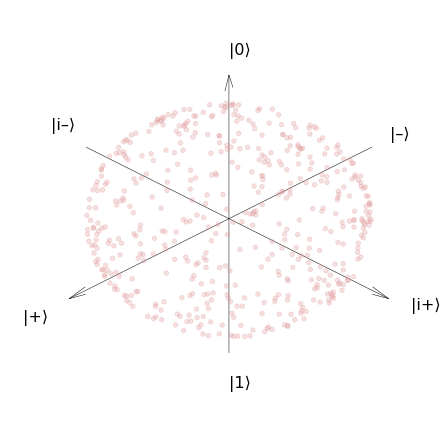

In [10]:
plot_bloch_sphere(original_states)

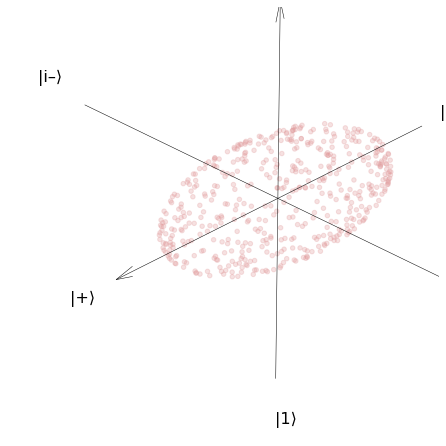

In [11]:
plot_bloch_sphere(flipped_states)

## Demo 2: depolarizing noise

## Demo 3: fidelity and trace distance

$$
F(\rho, \sigma) = \left( \hbox{Tr} \sqrt{\sqrt{\rho}\sigma\sqrt{\rho}} \right)^2
$$

In [12]:
from scipy.linalg import sqrtm

In [13]:
def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner_thing = np.linalg.multi_dot([sqrt_rho, sigma, sqrt_rho])
    return np.trace(sqrtm(inner_thing)) ** 2

In [14]:
proj_0 = np.array([[1, 0], [0, 0]])
proj_1 = np.array([[0, 0], [0, 1]])

In [15]:
fidelity(proj_0, proj_0)

1.0

In [16]:
fidelity(proj_0, proj_1)

0.0

$$
T(\rho, \sigma) = \frac{1}{2} \hbox{Tr} \left( \sqrt{(\rho - \sigma)^\dagger (\rho - \sigma)} \right)
$$

In [17]:
def trace_distance(rho, sigma):
    rms = rho - sigma
    inner_thing = np.dot(rms.conj().T, rms)
    return 0.5 * np.trace(sqrtm(inner_thing))

In [21]:
U = unitary_group.rvs(2)

p_vals = np.linspace(0, 1, 10)

In [22]:
fids = []
tr_ds = []

for p in p_vals:
    original_state = prepare_state(U, 0)
    error_state = prepare_state(U, p)
    
    fids.append(fidelity(original_state, error_state))
    tr_ds.append(trace_distance(original_state, error_state))

/opt/conda/envs/pennylane/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


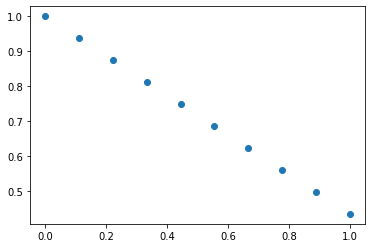

In [23]:
plt.scatter(p_vals, fids)

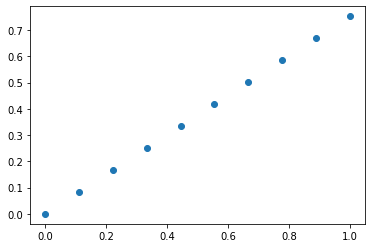

In [24]:
plt.scatter(p_vals, tr_ds)

## Demo 4: VQE for $H_2$ molecule

In [25]:
bond_length = 1.3228
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -bond_length/2, 0.0, 0.0, bond_length/2])

In [27]:
H, n_qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

In [29]:
print(H)

  (-0.2427450172749822) [Z2]
+ (-0.2427450172749822) [Z3]
+ (-0.04207254303152995) [I0]
+ (0.17771358191549907) [Z0]
+ (0.17771358191549919) [Z1]
+ (0.12293330460167415) [Z0 Z2]
+ (0.12293330460167415) [Z1 Z3]
+ (0.16768338881432715) [Z0 Z3]
+ (0.16768338881432715) [Z1 Z2]
+ (0.17059759240560826) [Z0 Z1]
+ (0.17627661476093917) [Z2 Z3]
+ (-0.04475008421265302) [Y0 Y1 X2 X3]
+ (-0.04475008421265302) [X0 X1 Y2 Y3]
+ (0.04475008421265302) [Y0 X1 X2 Y3]
+ (0.04475008421265302) [X0 Y1 Y2 X3]


Ground state of $H_2$ looks like:

$$
|\psi_g(\theta)\rangle = \cos(\theta/2) |1100\rangle - \sin(\theta/2) |0011\rangle
$$

In [30]:
dev = qml.device("default.qubit", wires=4)

def prepare_ground_state(theta):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.DoubleExcitation(theta, wires=range(4))
    return qml.expval(H)

In [32]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)

ideal_qnode = qml.QNode(prepare_ground_state, dev)

theta = np.array(0.0, requires_grad=True)
energies = []

for _ in range(30):
    theta, _energy = opt.step_and_cost(ideal_qnode, theta)
    energies.append(_energy)

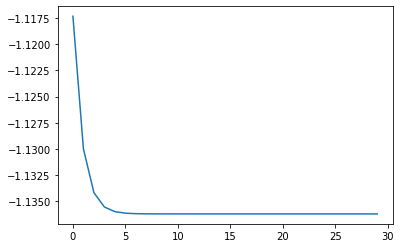

In [33]:
plt.plot(energies)

In [34]:
energies[-1]

array(-1.13618916)

In [35]:
theta

tensor(0.20973288, requires_grad=True)

## Demo 5: VQE on a noisy device

In [36]:
from qiskit.test.mock import FakeSantiago
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

In [37]:
device = QasmSimulator.from_backend(FakeSantiago())

noise_model = NoiseModel.from_backend(device, readout_error=False)

noisy_dev = qml.device(
    "qiskit.aer", backend='qasm_simulator', wires=4, shots=10000, noise_model=noise_model
)

In [38]:
noisy_qnode = qml.QNode(prepare_ground_state, noisy_dev)

In [39]:
noisy_qnode(theta)

-1.0843496220588662

In [40]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)

theta = np.array(0.0, requires_grad=True)

noisy_energies = []

for it in range(30):
    if it % 5 == 0:
        print(f"it = {it}")
    theta, _energy = opt.step_and_cost(noisy_qnode, theta)
    noisy_energies.append(_energy)

it = 0
it = 5
it = 10
it = 15
it = 20
it = 25


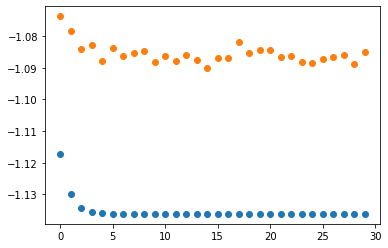

In [41]:
plt.scatter(range(30), energies)
plt.scatter(range(30), noisy_energies)

## Demo 6: zero-noise extrapolation